# Neural style transfer in TensorFlow

This notebook is based on the tutorial: https://www.tensorflow.org/tutorials/generative/style_transfer

_"Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image."_

## Setup

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  """Convert tensor to image.
  PIL (Python Imaging Library) expects the pixel values in an image to be represented as
  unsigned 8-bit integers with values between 0 and 255
  """
  # Convert pixel values in the tensor to the range [0,255]
  tensor = tensor*255
  # Convert to a numpy array with unsigned 8-bit integers
  tensor = np.array(tensor, dtype=np.uint8)

  # If the tensor has a batch dimension, remove it
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
    
  return PIL.Image.fromarray(tensor)

Set the style image and a content image paths:

In [5]:
content_path = 'sphynx_cat.jpg'
style_path = 'adele_block_from_klimt.jpg'

## Visualize the input

In [6]:
def load_img(path_to_img):
  """
  Loads an image from a file path and returns a tensor of shape (1, height, width, channels)
  with pixel values scaled to the range [0, 1].
  The input image size is limited to a manageable size that can be processed efficiently by the model
  """
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)

  # Convert pixel values to `float32` and scale values to range [0, 1]
  img = tf.image.convert_image_dtype(img, tf.float32) 

  # Set max. dimension (either width or height)
  max_dim = 512 

  # Resize image preserving aspect ratio
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim  
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape) 

  # Add extra dimension to the tensor (batch size)
  img = img[tf.newaxis, :]
  return img

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    # Remove the batch size dimension
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

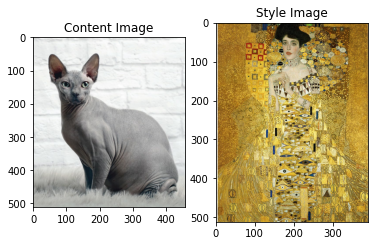

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [9]:
content_image.shape

TensorShape([1, 512, 459, 3])

In [10]:
style_image.shape

TensorShape([1, 512, 391, 3])

## Fast Style Transfer using TF-Hub

In [11]:
! pip install tensorflow_hub


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


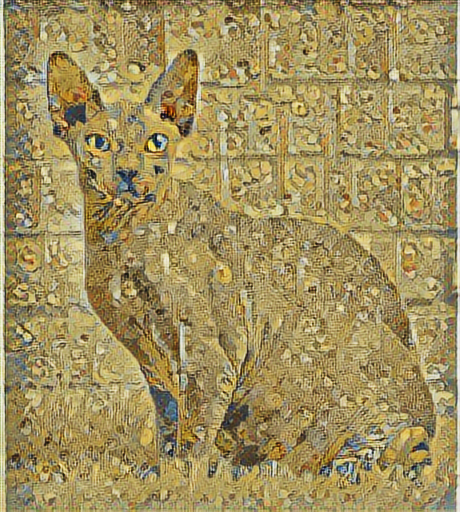

In [12]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Use the intermediate layers of the model to get the content and style representations of the image. In this case, we are using the VGG19 network architecture, a pretrained image classification network

Load a VGG19 and test run it on our image to ensure it's used correctly:

In [13]:
# Note: By multiplying the content image by 255 before applying preprocess_input(), 
#       we are effectively scaling the pixel values of the image to the range of [0, 255] 
#       so that they can be properly centered and normalized by the preprocess_input() function. 
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [14]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Mexican_hairless', 0.9890209),
 ('Egyptian_cat', 0.005817149),
 ('Siamese_cat', 0.0032446424),
 ('Chihuahua', 0.0013881008),
 ('toy_terrier', 0.00021702555)]

Now load a VGG19 and list the layer names

In [15]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


Choose intermediate layers from the network to represent the style and content of the image:

In [16]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

_So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?_

_At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image._

_This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, **the model serves as a complex feature extractor**. By accessing intermediate layers of the model, you're able to describe the content and style of input images._

## Build the model

In [17]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values"""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [18]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 391, 64)
  min:  0.0
  max:  872.6886
  mean:  42.494915

block2_conv1
  shape:  (1, 256, 195, 128)
  min:  0.0
  max:  4859.859
  mean:  209.17781

block3_conv1
  shape:  (1, 128, 97, 256)
  min:  0.0
  max:  11747.504
  mean:  200.71754

block4_conv1
  shape:  (1, 64, 48, 512)
  min:  0.0
  max:  36412.504
  mean:  759.1309

block5_conv1
  shape:  (1, 32, 24, 512)
  min:  0.0
  max:  4039.3918
  mean:  56.124134



_The content of an image is represented by the values of the intermediate feature maps._

We can see that first layer of VGG, `block1_conv1`,  has 64 filters. Visualizing the intermediate feature maps for this layer:

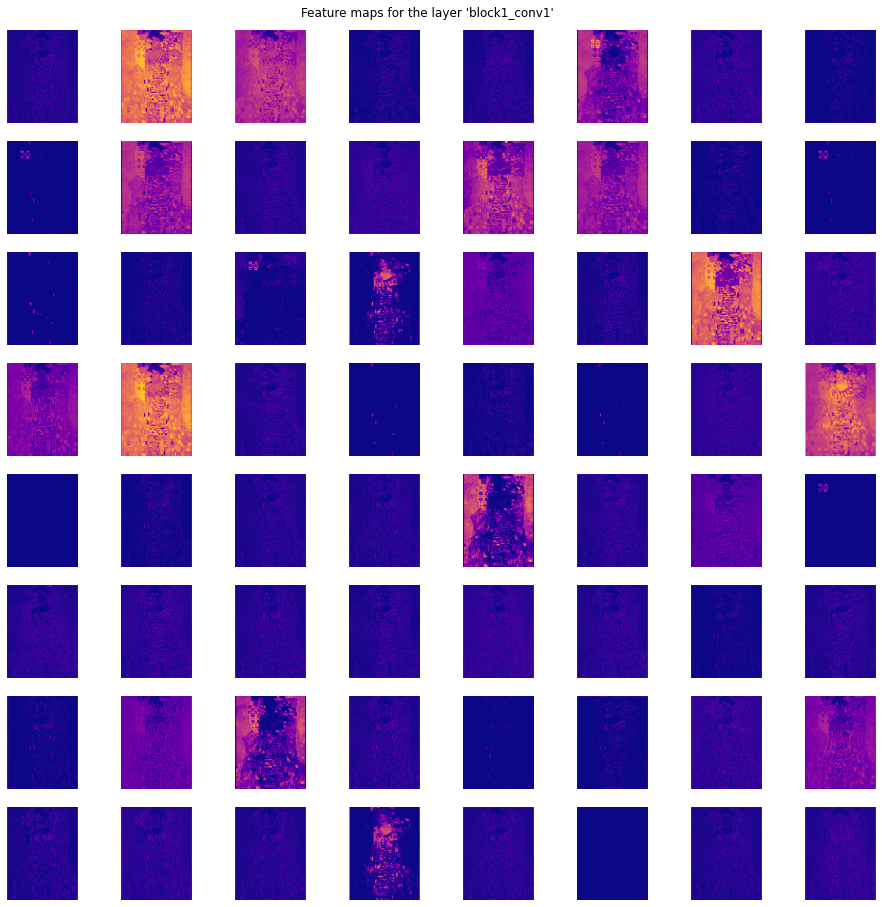

In [19]:
import matplotlib.pyplot as plt

# Extract the output of the first layer of VGG (block1_conv1)
output = style_outputs[0]

# Visualize the feature maps
fig, axs = plt.subplots(8, 8, figsize=(16, 16))
fig.suptitle("Feature maps for the layer 'block1_conv1'" , y=0.9)

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(output[0, :, :, i*8+j], cmap='plasma')
        axs[i, j].axis('off')

_It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations_

In [20]:
def gram_matrix(input_tensor):
    """
    Calculates the Gram matrix of the given input tensor.

    The Gram matrix is calculated by taking the outer product of the feature vector with itself at each location,
    and then averaging that outer product over all locations.

    input_tensor: A 4D tensor of shape (batch_size, height, width, channels).

    Returns: A 3D tensor of shape (channels, channels), which represents the Gram matrix of the input tensor.
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

## Extract style and content

Build a model that returns the style and content tensors.

In [21]:
class StyleContentModel(tf.keras.models.Model):
    
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    """Expects float input in [0,1]"""
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [22]:
style_content_model = StyleContentModel(style_layers, content_layers)

results = style_content_model(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00034734138
    max:  90811.74
    mean:  324.17557

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  102570.58
    mean:  9279.963

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  172143.05
    mean:  7197.5186

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2077507.5
    mean:  115873.16

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  61168.87
    mean:  980.4558

Contents:
   block5_conv2
    shape:  (1, 32, 28, 512)
    min:  0.0
    max:  1745.8132
    mean:  11.255303


# Run gradient descent
With this style and content extractor, we can now implement the style transfer algorithm. We do this by calculating the mean square error for your image's output relative to each target, then taking the weighted sum of these losses.

Set style and content target values:

In [23]:
style_targets = style_content_model(style_image)['style']
content_targets = style_content_model(content_image)['content']

Define a `tf.Variable` to contain the image to optimize

In [24]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [25]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer

In [26]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [27]:
style_weight=1e-2
content_weight=1e5 # Original one was 1e4

def style_content_loss(outputs):
    """Calculates  total loss for the style transfer model.
    The loss is composed by the style loss and the content loss.
    
    outputs: Dictionary containing the output feature maps of the VGG19 model for both the style and content images
    """
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Style loss:  MSE between Gram matrices of the output feature maps and the target style feature maps
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # Content loss: MSE between  output feature maps and  target content feature maps
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    return loss

Use tf.GradientTape to update the image.

In [28]:
outputs = style_content_model(image)

In [29]:
@tf.function()
def train_step(image):
  """Perform a single training step for a style transfer model.
  The @tf.function() decorator is used to convert the Python code into a TensorFlow graph, which can be optimized for faster execution.
  """
  with tf.GradientTape() as tape:
    outputs = style_content_model(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

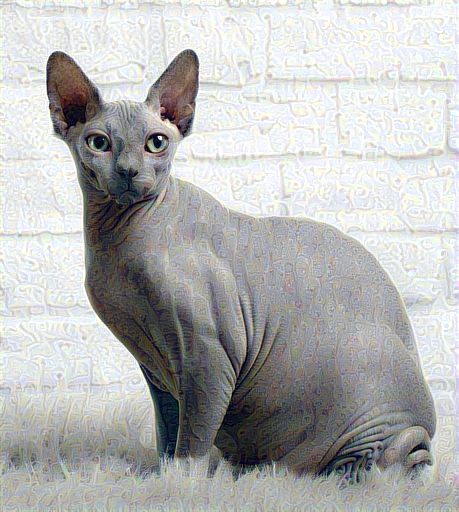

In [30]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Perform a longer optimization

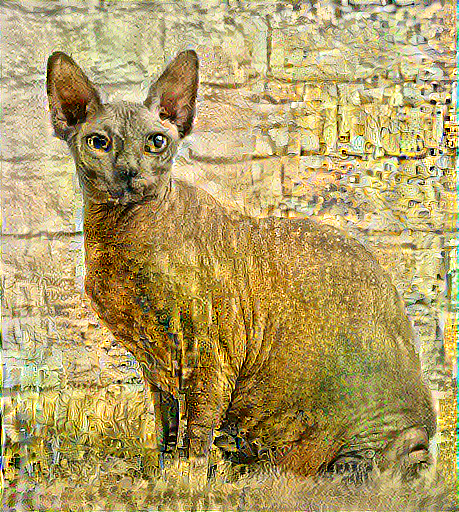

Train step: 500
Total time: 2444.7


In [31]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

In [32]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

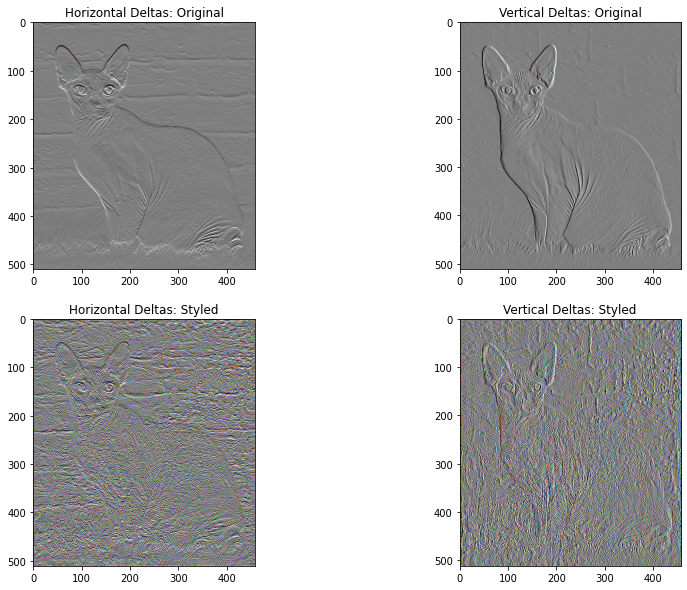

In [33]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

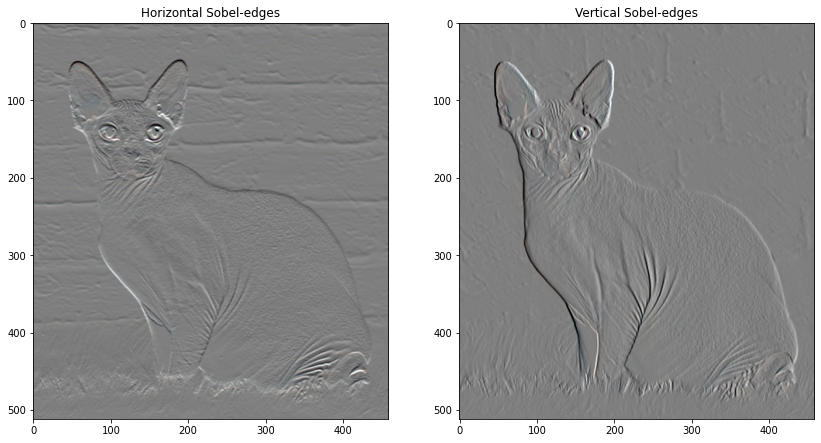

In [34]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [35]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [36]:
total_variation_loss(image).numpy()

188985.38

TensorFlow implementation

In [37]:
tf.image.total_variation(image).numpy()

array([188985.38], dtype=float32)

## Re-run the optimization

In [30]:
total_variation_weight=500 #300

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = style_content_model(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [31]:
image = tf.Variable(content_image)

And run the optimization:

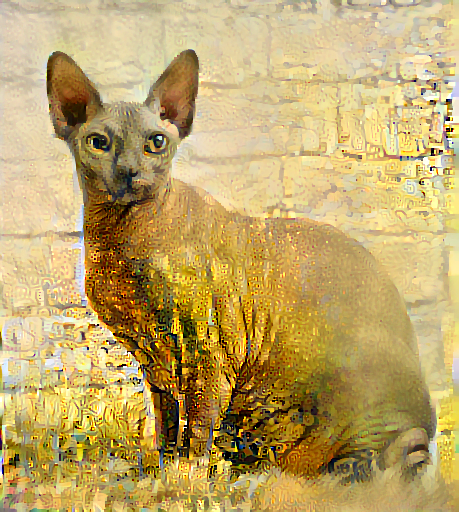

Train step: 500
Total time: 3071.4


In [32]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [33]:
tensor_to_image(image).save("cat_klimt_style_transfer_tf_500_iter_500_tv.jpg")

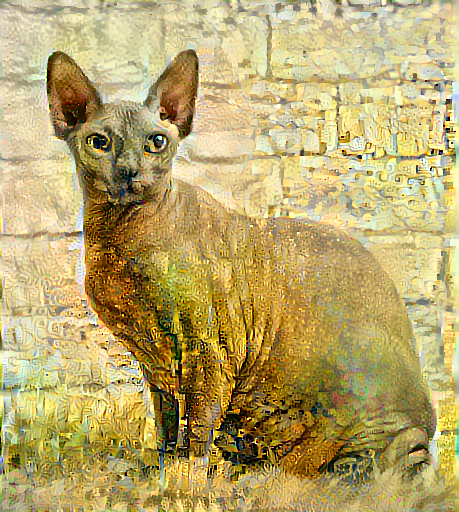

Train step: 350
.....................

In [ ]:
# Previous one: total_variation_weight=300